In [1]:
%load_ext autoreload
%autoreload 2
import sys; import os
sys.path.append(os.path.abspath('../'))
from src import data_handlers, matrix_ops
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from scipy import sparse

# Load Preprocessed DataFrames

Load the prepocessed Data Frames provided by:
- US Government 
- Chair of Financial Management and Capital Markets 

Preprocessing includes:
- Dropping duplicates
- Apply Regex patterns
- Correction of the addresses

In [2]:
usa_df = pd.read_csv('../processed/processed_usa.csv', low_memory = False)
usa_df.shape

(6442676, 29)

##  US Spending DF

In [3]:
usa_df.head()

,recipient_duns,recipient_name,recipient_doing_business_as_name,recipient_parent_duns,recipient_parent_name,recipient_country_code,recipient_country_name,recipient_address_line_1,recipient_address_line_2,recipient_city_name,...,recipient_zip_code,recipient_zip_last_4_code,recipient_foreign_city_name,recipient_foreign_province_name,recipient_foreign_postal_code,clean_recipient_name,clean_recipient_parent_name,clean_recipient_doing_business_as_name,recipient_address_line_fixed,recipient_state_fixed
0,139032531,ISOTEK SYSTEMS LIMITED LIABILITY COMPANY,NaN,139032531,ISOTEK SYSTEMS LLC,UNITED STATES,NaN,700 S ILLINOIS AVE,SUITE A102,OAK RIDGE,...,NaN,NaN,NaN,NaN,NaN,ISOTEK SYSTEMS LLC,ISOTEK SYSTEMS LLC,NaN,700 SAN ILLINOIS AVENUE SUITE A102,TENNESSEE
1,168599863,TRUSTON TECHNOLOGIES INCORPORATED,NaN,168599863,TRUSTON TECHNOLOGIES INC.,UNITED STATES,NaN,102 RUE DU PAIN,NaN,BROUSSARD,...,NaN,NaN,NaN,NaN,NaN,TRUSTON TECHNOLOGIES INC,TRUSTON TECHNOLOGIES INC,NaN,102 RUE DU PAIN,LOUISIANA
2,005144808,"PALOMAR PRODUCTS, INC.",NaN,043190826,ESTERLINE TECHNOLOGIES CORP,USA,UNITED STATES,23042 ARROYO VISTA,NaN,RCHO STA MARG,...,NaN,NaN,NaN,NaN,NaN,PALOMAR PRODUCTS INC,ESTERLINE TECHNOLOGIES CORP,NaN,23042 ARROYO VISTA,CALIFORNIA
3,118759695,"LCL ELECTRONICS, INC.",NaN,118759695,LCL ELECTRONICS INC.,USA,UNITED STATES,8148 INDUSTRIAL PARK RD,NaN,BAXTER,...,NaN,NaN,NaN,NaN,NaN,LCL ELECTRONICS INC,LCL ELECTRONICS INC,NaN,8148 INDUSTRIAL PARK ROAD,MINNESOTA
4,174786913,NORTHROP GRUMMAN SHIP SYSTEMS INCORPORATED,NaN,967356127,NORTHROP GRUMMAN CORPORATION,USA,UNITED STATES OF AMERICA,1000 ACCESS RD,NaN,PASCAGOULA,...,NaN,NaN,NaN,NaN,NaN,NORTHROP GRUMMAN SHIP SYSTEMS INC,NORTHROP GRUMMAN CORP,NaN,1000 ACCESS ROAD,MISSISSIPPI


## Chair of Financial Management and Capital Markets DF


In [4]:
chair_df = pd.read_csv('../processed/processed_chair.csv', low_memory = False)

In [5]:
chair_df.head()

,gvkey,conm,conml,state,add1,add2,add3,add4,addzip,clean_conm,add_fixed,state_fixed
0,1000,A & E PLASTIK PAK INC,A & E Plastik Pak Inc,NaN,NaN,NaN,NaN,NaN,NaN,A&E PLASTIK PAK INC,NaN,NaN
1,1001,A & M FOOD SERVICES INC,A & M Food Services Inc,OK,1924 South Utica Avenue,NaN,NaN,NaN,94104,A&M FOOD SVCS INC,1924 SOUTH UTICA AVENUE,OKLAHOMA
2,1002,AAI CORP,AAI Corp,MD,124 Industry Lane,NaN,NaN,NaN,21030-0126,AAI CORP,124 INDUSTRY LANE,MARYLAND
3,1003,A.A. IMPORTING CO INC,A.A. Importing Co Inc,MO,7700 Hall Street,NaN,NaN,NaN,63125,AA IMPORTING CO INC,7700 HALL STREET,MISSOURI
4,1004,AAR CORP,AAR Corp,IL,"One AAR Place, 1100 North Wood Dale Road",NaN,NaN,NaN,60191,AAR CORP,1 AAR PLACE 1100 NORTH WOOD DALE ROAD,ILLINOIS


# Candidate Selection

To detect similarity of two documents from the 2 datasets, we vectorized the company names in dataframes.

With the preprocessed datasets, we first create a vocabulary that consists of every single word included in company names. These company names are taken from preprocessed names - `conm` in the CFMCM dataset, `recipient_name`, `recipient_parent_name`, `recipient_doing_business_as_name` in the USA Spending dataset.

Then, we represent each company name with a vector using the vocabulary we have. Once we convert our names to vectors, we calculate how similar they are, using the cosine similary measure.

In addition to similarities in names, we also take into account the similarities in geolocations. We use address information to accomplish this.

At the end, we combine name similarity and geolocation similarity to compute the final similarity score.

##  Vectorization 

In vectorization we aim to represent each company name with a vector. In this vector, only cells that correspond to the words included in the name should have non-zero values. The rest of the vector should be zero.

If we set all non-zero values to 1, then each word would have the same importance when calculating the name similarity (i.e. the similarity between the vectors). On the contrary, we want to give each word a weigth that corresponds to its importance. We calculate this "importance" using tf-idf.

In the tf-idf (Term Frequency - Inverse Document Frequency) measure, terms that occur frequently have a smaller effect than the ones that occur rarely. In practice, this forces common words like 'inc' or 'corp' to have a smaller effect on the similarity scores whereas company-specific words such as 'AT&T' has a higher weigth.

To train the vectorizer we used a corpus that includes unique preprocessed company names in the two datasets.

At the end, for each company name, we create a weighted sparse vector with size equal to vocabulary's.

In [6]:
companies = data_handlers.get_unique_company_names(usa_df)
companies.shape

(2338216,)

In [7]:
vectorizer = TfidfVectorizer(analyzer='word', token_pattern= r'\S+')
#tfidf = vectorizer.fit_transform(chair_df.conm)
vectorizer.fit(pd.concat([chair_df.clean_conm, pd.Series(companies)]).unique())
tfidf = vectorizer.transform(chair_df.clean_conm)
tfidf_USA = vectorizer.transform(companies)

### IDF scores of the most common words

As expected, weights of the most common words are the smallest.

In [8]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf = df_idf.sort_values(by=['idf_weights'])
df_idf.head(20)

,idf_weights
inc,2.354230
llc,2.808583
and,3.354617
of,3.920017
trust,4.197939
co,4.461891
corp,4.552909
svcs,4.711038
the,4.763321
farms,4.765806


# IDF Distribution of the Vocabulary
Most of the company names includes some company specific words. This results can also be seen in the distribution of the idfs (inverse document frequencies). Most of our vocabulary consists of words that occur rarely, thus have high idf (inverse document frequency).

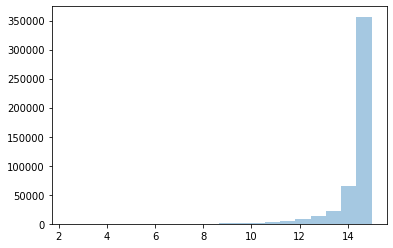

In [9]:
sns.distplot(vectorizer.idf_, kde=False, bins=20)

## Calculate Cosine Similarity Matrix

After we vectorized the company names we calculated the cosine similarity between each company name in the CFMCF (Chair of Financial Management and Capital Markets) Dataset and the US Government Dataset.

The resulting cosine similarity matrix has massive size (28k to 2 million). To be able to store it in the memory we selected candidates that have a cosine similarity larger than a given threshould (0.4) and we stored the result in a sparse matrix to eliminate zeros. 

In [10]:
THRES = 0.4
cosine_similarities, max_similarities = matrix_ops.get_cosine_similarities(tfidf, tfidf_USA, THRES)

/home/sirin/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


0 of 28816 documents are calculated
1000 of 28816 documents are calculated
2000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated
6000 of 28816 documents are calculated
7000 of 28816 documents are calculated
8000 of 28816 documents are calculated
9000 of 28816 documents are calculated
10000 of 28816 documents are calculated
11000 of 28816 documents are calculated
12000 of 28816 documents are calculated
13000 of 28816 documents are calculated
14000 of 28816 documents are calculated
15000 of 28816 documents are calculated
16000 of 28816 documents are calculated
17000 of 28816 documents are calculated
18000 of 28816 documents are calculated
19000 of 28816 documents are calculated
20000 of 28816 documents are calculated
21000 of 28816 documents are calculated
22000 of 28816 documents are calculated
23000 of 28816 documents are calculated
24000 of 28816 documents are calculated
25000 of 2881

### Load cosine similarity matrix

In [12]:
cosine_similarities  = sparse.load_npz('../processed/cosine_similarities.npz')
max_similarities = np.load('../processed/max_similarities.npy')
cosine_similarities

<28816x2338216 sparse matrix of type '<class 'numpy.float64'>'
	with 4807631 stored elements in Compressed Sparse Row format>

## Distribution of the Highest Cosine Similarities per Chair Company Name
After the preprocessing we see the number of exact matches as high as 7 thousand. 

Another observetion is that in the chair dataset there are company names for which only low quality matches exist. 

An example of a such case is having no company name in the US Government datasets that matches the name in the Chair Dataset but having companies that have same company type as 'inc'. In such a case, since 'inc' has very low IDF, the cosine similarity will also be very low even for the best match.

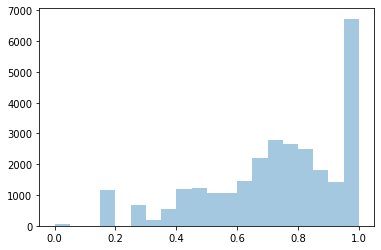

In [13]:
sns.distplot(max_similarities, kde=False, bins=20)

## Selection of the Best Candidates
After calculating the cosine similarity between the companies, we end up with an average of 200 candidates for each company in the CFMCF dataset.

In our selection of the best candidate we intruduce a bonus point on top of the cosine similarity measure based on __geolocation__.
The default bonuses that we selected are as:
- same state bonus = 0.05
- same country bonus = 0.1
- same address bonus = 0.3

Afterwards the selection of the best candidate is done using this combined score metric.

In [95]:
best_matches = matrix_ops.get_best_candidates(chair_df, usa_df, cosine_similarities, companies, 
                                              zip_bonus = 0.1, state_bonus=0.05, address_bonus= 0.3 )

0 of 28816 documents are calculated
1000 of 28816 documents are calculated
2000 of 28816 documents are calculated
3000 of 28816 documents are calculated
4000 of 28816 documents are calculated
5000 of 28816 documents are calculated
6000 of 28816 documents are calculated
7000 of 28816 documents are calculated
8000 of 28816 documents are calculated
9000 of 28816 documents are calculated
10000 of 28816 documents are calculated
11000 of 28816 documents are calculated
12000 of 28816 documents are calculated
13000 of 28816 documents are calculated
14000 of 28816 documents are calculated
15000 of 28816 documents are calculated
16000 of 28816 documents are calculated
17000 of 28816 documents are calculated
18000 of 28816 documents are calculated
19000 of 28816 documents are calculated
20000 of 28816 documents are calculated
21000 of 28816 documents are calculated
22000 of 28816 documents are calculated
23000 of 28816 documents are calculated
24000 of 28816 documents are calculated
25000 of 2881

In [117]:
# remove .0 from the end of the duns addresses ex: 012313.0 -> 012313
best_matches.recipient_duns = best_matches.recipient_duns.astype('str').str.replace('.0$', '').replace('nan',np.nan)

## Cosine Similarity Scores Distribution of the Best Candidates

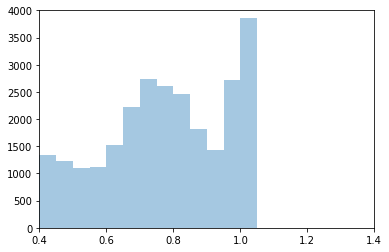

In [106]:
g = sns.distplot(list(best_matches.cos_sim.dropna()), kde=False,bins=np.arange(0, 1.41, 0.05))
_ = g.set(ylim=(0, 4000), xlim=(0.4,1.4))

## With Bonus Scores Distribution of the Best Candidates
We see a shift in scores due to the bonus points given by geolocation similarities

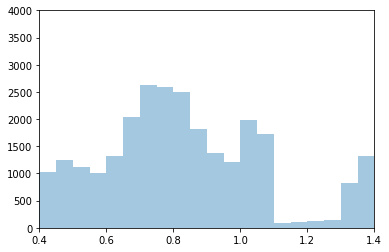

In [107]:
g = sns.distplot(list(best_matches.score.dropna()), kde=False, bins=np.arange(0, 1.41, 0.05))
_ = g.set(ylim=(0, 4000), xlim=(0.4,1.4))

## Random Selection of the Best Candidates

In [108]:
columns = ['gvkey','conm','recipient_name','recipient_parent_name','recipient_doing_business_as_name',
           'recipient_duns','cos_sim','score']
best_matches[columns].dropna(how='all').sample(10)

,gvkey,conm,recipient_name,recipient_parent_name,recipient_doing_business_as_name,recipient_duns,cos_sim,score
28086,186046,DIREXION DLY GOLD MINERS BU,"GOLD MINERS INN, LLC",GOLD MINERS INN LLC,NaN,615448961.0,0.518358,0.518358
11810,14399,INFORMATION MGMT TECH -CL A,INFORMATION TECH,INFORMATION TECH,NaN,962018651,0.868111,0.868111
10244,12351,MACANDREWS & FORBES HOLDINGS,"AM GENERAL, LLC",MACANDREWS & FORBES HOLDINGS INC.,NaN,612020933,0.9924,0.9924
18575,31683,FINLAY ENTERPRISES INC,"FINLAY GROUP, LLC",NaN,NaN,19086622.0,0.82906,0.82906
10300,12420,JIFFY LUBE INTL,JIFFY LUBE,NaN,NaN,149020971,0.93408,0.93408
28069,185965,NUVEEN BUILD AMERICA BD OPP,"BUILD AMERICA, LLC.",NaN,NaN,79103182.0,0.5477,0.5477
16338,25650,FUNCO INC,FUNCO GAME MFG,FUNCO MOTORSPORTS INC,NaN,036934396,0.832419,0.832419
8490,10336,TARGA OIL & GAS INC,TARGA INSURANCE INC.,NaN,NaN,NaN,0.694831,0.694831
14018,19720,SOUTHERN CONCEPTS RESTAURANT,RESTAURANT CONCEPTS INC,RESTAURANT CONCEPTS INC,NaN,173344037,0.807522,0.807522
3218,4577,FARM FRESH INC,FARM FRESH INC,NaN,NaN,23718856.0,1,1


## Random Selection of the Best Candidates with Score Threshold

In [124]:
QUALITY_THRES = 0.8
selections = best_matches[best_matches.score>QUALITY_THRES]
selections[columns].sample(20)

,gvkey,conm,recipient_name,recipient_parent_name,recipient_doing_business_as_name,recipient_duns,cos_sim,score
10580,12747,GATEWAY MEDICAL SYSTEMS INC,GATEWAY MEDICAL INC,GATEWAY MEDICAL INC,NaN,1192612,0.89481,0.89481
18962,61398,LECROY CORP,LECROY CORPORATION,LECROY CORPORATION,NaN,0016369,1,1.35
1790,3009,CHILTON CORP,CHILTON MFG CORP.,NaN,NaN,6424089,0.877504,0.877504
1161,2259,BLACK HILLS CORP,BLACK HILLS CORPORATION,NaN,NaN,7920333,1,1.35
5681,7283,METAL ARTS CO INC,"METAL ARTS, L.L.C.",METAL ARTS L.L.C.,NaN,53084356,0.876169,0.876169
7545,9305,S & K FAMOUS BRANDS INC,"S & K FAMOUS BRANDS, INC",NaN,NaN,0412872,1,1.05
15747,24667,BIOWHITTAKER INC,BIOWHITTAKER INC,LONZA GROUP AG,NaN,609095955,1,1.35
702,1755,ARMCO INC,ARMCO CONSTRUCTION INC,ARMCO CONSTRUCTION INC,NaN,197340151,0.932181,0.982181
16317,25619,PRECISION SYSTEMS INC,PRECISION SYSTEMS INC,PRECISION SYSTEMS INC,NaN,001001676,1,1
10937,13187,EACO CORP-OLD,"BISCO INDUSTRIES, INC.",EACO CORPORATION,NaN,0644092,1,1.05


## Save Results

In [130]:
print(f'We managed to match { best_matches.score.dropna().shape[0]} matches out of { chair_df.shape[0] } company names.')
print(f'{selections.shape[0]} of these pass the similarity score threshold of {QUALITY_THRES}.')

We managed to match 26165 matches out of 28816 company names.
13198 of these pass the similarity score threshold of 0.8.


In [126]:
best_matches[columns].dropna(how='all').to_csv('../results/matching_table.csv')
selections[columns].to_csv('../results/matching_table_with_threshold.csv')